# Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1
high_degree = 10

In [2]:
assert testcase in [1,2]
if testcase == 1:
    assert version in [1,2,4]
else:
    assert version == 1

**Idée :** On se place ici dans un des cas tests proposés : TestCase1,1_v2,2.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from modfenics.solver_fem.PoissonDirSquareFEMSolver import PoissonDirSquareFEMSolver
from modfenics.utils import get_param,compute_slope
from testcases.utils import create_tree

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/u2/lecourtier/miniconda3/envs/fenics_scimba_modules/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [5]:
if testcase == 1:
    if version == 1:
        from testcases.networks.test_2D.test_1.test_1_v1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from testcases.networks.test_2D.test_1.test_1_v2 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from testcases.problem.problem_2D import TestCase1
    problem = TestCase1()
elif testcase == 2:
    from testcases.networks.test_2D.test_2.test_2_v1 import Run_laplacian2D,Poisson_2D
    from testcases.problem.problem_2D import TestCase2
    problem = TestCase2()

result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

/home/u2/lecourtier/Article1
torch loaded; device is cpu


/home/u2/lecourtier/Article1
>> load network /home/u2/lecourtier/Article1/networks/test_2D/test_fe1.pth
network loaded
Error  tensor([0.0038])


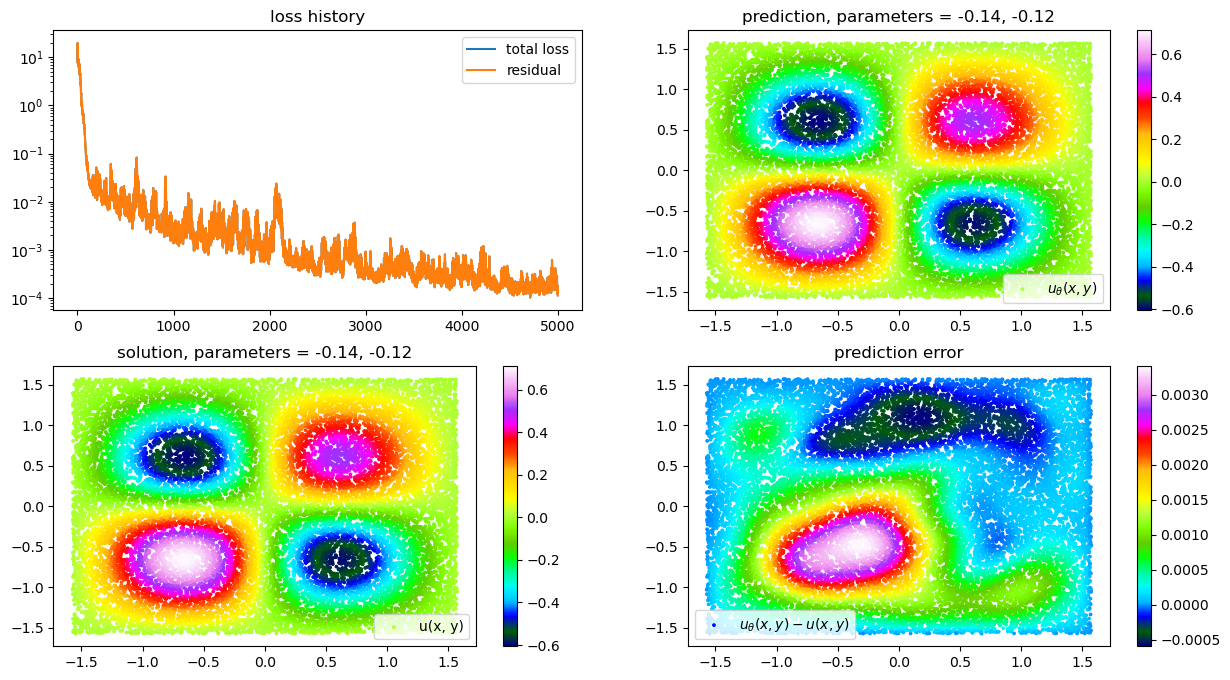

In [6]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [7]:
param = get_param(param_num,trainer.pde.parameter_domain.cpu().numpy())
params = [param]
print(param)

[0.05 0.22]


## Convergence FEM

In [8]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        solver = PoissonDirSquareFEMSolver(params=params, problem=problem, degree=degree, high_degree=high_degree)
        for nb_vert in tab_nb_vert_FEM:
            solver.set_meshsize(nb_cell=nb_vert-1)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [9]:
degree = 2
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv


degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv


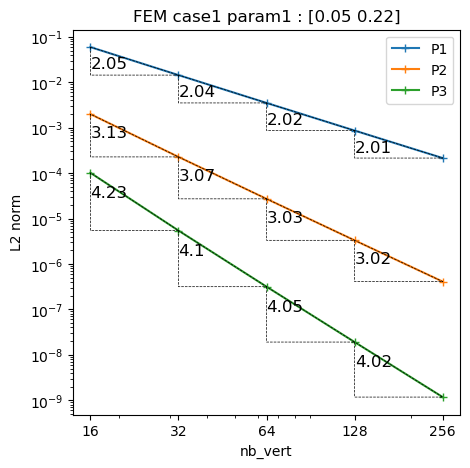

In [10]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    for i in range(1,len(tab_nb_vert_FEM)):
        slope, vert_mid = compute_slope(i,tab_nb_vert_FEM,tab_err_FEM)
        plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [11]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv


## Convergence PINNs+Corr

In [11]:
def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        solver = PoissonDirSquareFEMSolver(params=params, problem=problem, degree=degree, high_degree=high_degree)
        for nb_vert in tab_nb_vert_Corr:
            solver.set_meshsize(nb_cell=nb_vert-1)
            tab_h_Corr.append(solver.h)
            _,_,norme_L2 = solver.corr_add(0,u_theta)            
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [12]:
d = 1
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)

V_ex created with  501  vertices and degree  4  : h_ex = 0.008885765876317436
Time to generate mesh:  0.0001747608184814453
Mesh created with  16  vertices : h = 0.29619219587722484
Time to assemble the matrix :  1.0133614540100098
Time to solve the system : 0.006117820739746094
Building point search tree to accelerate distance queries.
Computed bounding box tree with 899 nodes for 450 points.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
nb_vert=16, norme_L2=0.0002285194934775666


degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree3.csv


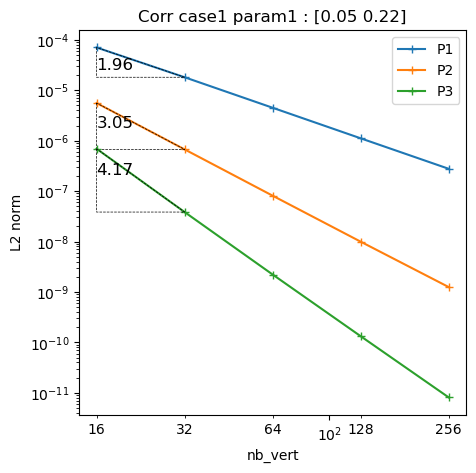

In [44]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    slope, vert_mid = compute_slope(1,tab_nb_vert_Corr,tab_err_Corr)
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [17]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree3.csv


## Plots

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/FEM_case1_param1_degree3.csv
degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree3.csv


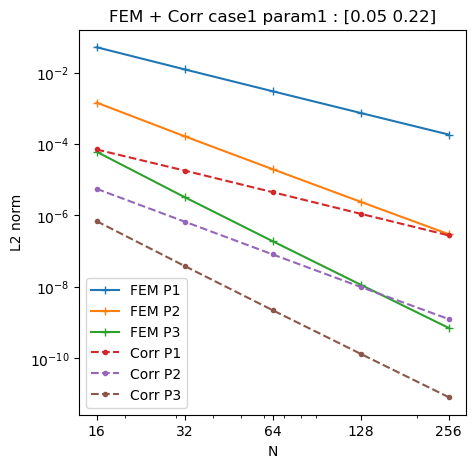

In [45]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')